In [1]:
#!py -m pip freeze > requirements.txt

In [1]:
from langchain import hub
from langchain_ollama.llms import OllamaLLM
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import AgentExecutor, create_react_agent
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.callbacks import StdOutCallbackHandler
import requests

import os

ModuleNotFoundError: No module named 'langchain_ollama'

In [3]:
# from langchain.globals import set_debug

# set_debug(True)


In [4]:
# TAVILY_API_KEY = os.environ["TAVILY_API_KEY"]
# os.environ["TAVILY_API_KEY"]

In [5]:
# Use llama3.1 and test if it is working
model = OllamaLLM(model="llama3.1", temperature=0)
model.invoke("Come up with 10 names for a song about parrots")

'Here are 10 potential song title ideas about parrots:\n\n1. **"Flock Together"** - a catchy, upbeat title that captures the social nature of parrots.\n2. **"Rainbow Wings"** - inspired by the vibrant colors and stunning plumage of many parrot species.\n3. **"Squawkin\' Good Time"** - a fun, playful title that evokes the lively sounds made by parrots.\n4. **"Paradise Found"** - a title that references the tropical habitats where many parrots live.\n5. **"Feathered Friends"** - a heartwarming title that highlights the special bond between humans and parrots.\n6. **"The Parrot\'s Lament"** - a more melancholic title that suggests a song with a deeper, more emotional message.\n7. **"Winged Wonders"** - a title that celebrates the incredible abilities of parrots in flight.\n8. **"Colorful Chaos"** - a fun, whimsical title that captures the playful energy of parrots.\n9. **"The Bird\'s Eye View"** - a clever title that references both the physical perspective of a bird and the idea of seein

## What are LLM Agents?

LLM agents refer to AI systems or agents powered by LLMs as their reasoning engines. They are designed to perform tasks autonomously by processing and generating human language.

<img src="https://lilianweng.github.io/posts/2023-06-23-agent/agent-overview.png" width="700">


In the following example, we will be creating LLM Agents using Langchain's Agent Framework


The 3 main components of the framework are

**Agents**

Agents act as a reasoning engine as they decide the appropriate actions to take and the order to take these actions. They make use of an LLM to make the decisions for them. An agent has an AgentExecutor that calls the agent and executes the tools the agent chooses. It also takes the output of the action and passes it to the agent until the final outcome is reached.

**Tools**

Tools are interfaces that the agent can make use of. In order to create a tool, a name and description needs to be provided. The description and name of the tool are important as it will be added into the agent prompt. This means that the agent will decide the tool to use based on the name and description provided.

**Chains**

A chain refer to sequences of calls. The chain can be coded out steps or just a call to an LLM or a tool. Chains can be customized or be used off-the-shelf based on what LangChain provides.

In [29]:
from langchain.agents import tool


@tool()
def get_number_active_cpf_members_and_employers(input: str) -> str:
    """Gets the number of all, Central Provident Fund (CPF) Members & Active Employers"""

    # We get the dataset ids of the following dataset: https://data.gov.sg/datasets?query=CPF&page=1&resultId=41
    # This will be needed as we will be querying the data.gov API later.
    dataset_dict = {
        "active_member": "d_89dd4e5486fe3bb3b0c620cc6f787cdc",
        "active_employer": "d_bccb6829056e74f8a87b99c1bdb3e3ab",
        "member": "d_0014a7b5fa44981567b4c99c7a126630"
    }

    # This chain is used to find out what type of question the user is asking
    question_classification_chain = model.invoke(f"""You are a chatbot tasked to identify if the following user query is asking for the 
                 1) Number of Central Provident Fund (CPF) active members. If user is asking for this, respond with active_member
                 2) Number of Central Provident Fund (CPF) active employers. If user is asking for this, respond with active_employer
                 3) Number of Central Provident Fund (CPF) members. If user is asking for this, respond with member

                 If you do not have the answer respond with 'I don't know'.
                                
                Query: {input}""")
    
    # This if else statement is to check if the LLM hallucinated or if it did not give the answer in the correct format.
    if question_classification_chain not in dataset_dict:
        return "I don't know"
    else:
        datasetId = dataset_dict[question_classification_chain]

    # This chain is used to find out the year and quarter the user is asking for. Ask LLM to default to 2024-Q1 if no year and quarter.
    year_quarter_chain = model.invoke(f"""You are a chatbot tasked to identify the year and quarter from the user query 
                 1) If you do not know the year reply 2024
                 2) If you do not know the quarter reply Q1

                 Format your answer in the followng format YYYY-QQ. Only reply with the YYYY-QQ.
                                
                Query: {input}""")

    year_quarter_chain = year_quarter_chain.strip()
     
    # Query data.gov to get number of CPF users or employers.
    url = "https://data.gov.sg/api/action/datastore_search"
    response = requests.get(url, params={"resource_id": datasetId})

    # This is to check if LLM hallucinated the year_quarter_chain
    result = "I don't know"
    for i in response.json()['result']['records']:
        if i['qtr'] == year_quarter_chain:
            result = i[list(i.keys())[2]]
    
    if result == "I don't know":
        return "I don't know"

    return f"\nObservation: {result}"


@tool()
def web_search(input: str) -> str:
    """Runs web search for generic Central Provident Fund (CPF) related questions"""
    
    # Tavily will search the web based on our query
    web_search_tool = TavilySearchResults()

    # Sometimes there might be errors when you use the API. Make sure to do proper exception handling!
    try:
        docs = web_search_tool.invoke({"query": input})
    except Exception as e:
        return f"Something went wrong using Tavily, {e}"
    
    # We summarize the results that the websearch gives us into a single output
    output = model.invoke(f"""You are text summarization tool that will ONLY help to summarize relevant information.
        Use following piece of context to answer the question. 
        If you don't know the answer or there is no relevant context, just say you don't know. 
        Keep the answer within 5 sentences and concise.

        Context: {docs[0:5]}
        Question: {input}
        Answer: 

        """)

    
    return f"\nObservation: {output}"


@tool(return_direct=True)
def send_email_to_CPF(input: str) -> str:
    """Use this tool to send an email to Central Provident Fund (CPF) if the user is reporting a scam, giving a compliment or if you are unable to answer questions after using the web_search tool"""
    
    # Mocked after https://www.cpf.gov.sg/service/write-to-us
    message_type_chain = model.invoke(f"You are a chatbot tasked with identifying the type of message that the user wrote. The type of message can be a Scam Report, Request, Appeal, Compliment, Feedback or Others. \n===CONVERSATION=== USER: {input}. MESSAGE_TYPE:"
                            )

    output = model.invoke(f"You are a chatbot tasked with writing an email to Central Provident Fund (CPF). Please come up with an email message based on the user's query. Do not include information about tools. \n MESSAGE TYPE: {message_type_chain} ===CONVERSATION=== USER: {input}. EMAIL:"
                            )
    
    # After this step we could take this output and format it into an email message before sending it to CPF. 
    # We could also extract user's NRIC and necessary fields that CPF requires for their contact us page.
    # It would require changes in the ReAct prompt to prompt users for missing information and we would need more LLM chains to extract the necessary information. This is out of the scope for this workshop, but you could react a whole workflow around this to extract & send the needed information via natural language.

    return output


@tool(return_direct=True)
def no_answer(input: str) -> str:
    """Come up with a generic fallback response when you get asked a question not related to Central Provident Fund (CPF)"""

    output = model.invoke(f"You are a chatbot that does not have sufficient information to answer the user's question. Please come up with a fallback response apologising to the user that you were not able to answer their question.\n===CONVERSATION=== USER: {input}. CHATBOT:"
                            )
    return output


tools = [
    get_number_active_cpf_members_and_employers,
    web_search,
    send_email_to_CPF,
    no_answer,
]

#get_number_active_cpf_members_and_employers.invoke("how many active cpf members are there?")
#web_search.invoke("what is CPF?")
#send_email_to_CPF.invoke("What is CPF?")

## ReAct Agent

We will be making use of a single agent system. The agent makes use of ReAct logic to determine the sequence of actions to take. Read more about it here: https://www.promptingguide.ai/techniques/react

This prompt engineering technique will help generate the following:

- Thought (Reasoning taken before choosing the action)

- Action (Action to take, often a tool)

- Action Input (Input to the action)

- Observation (Observation from the tool output)

- Final Answer (Generative final answer that the agent returns)

<img src="https://www.promptingguide.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Freact.8e7c93ae.png&w=1920&q=75" width="600">

This will be an overview of the LLM Agent we will be making today.

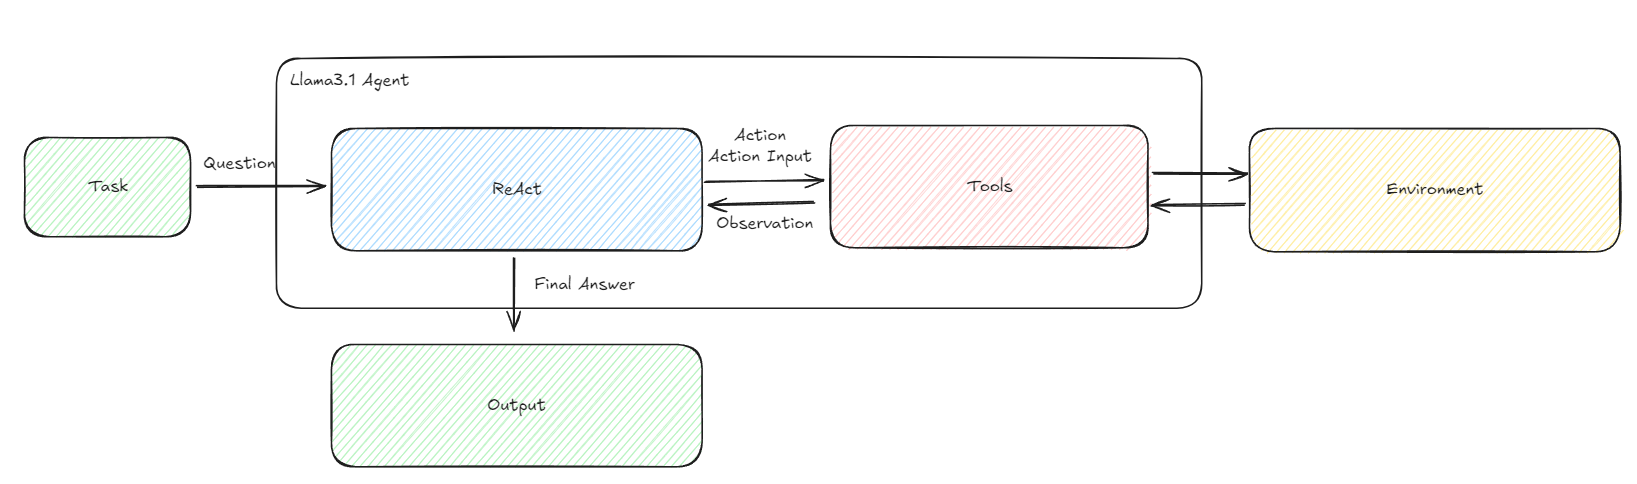

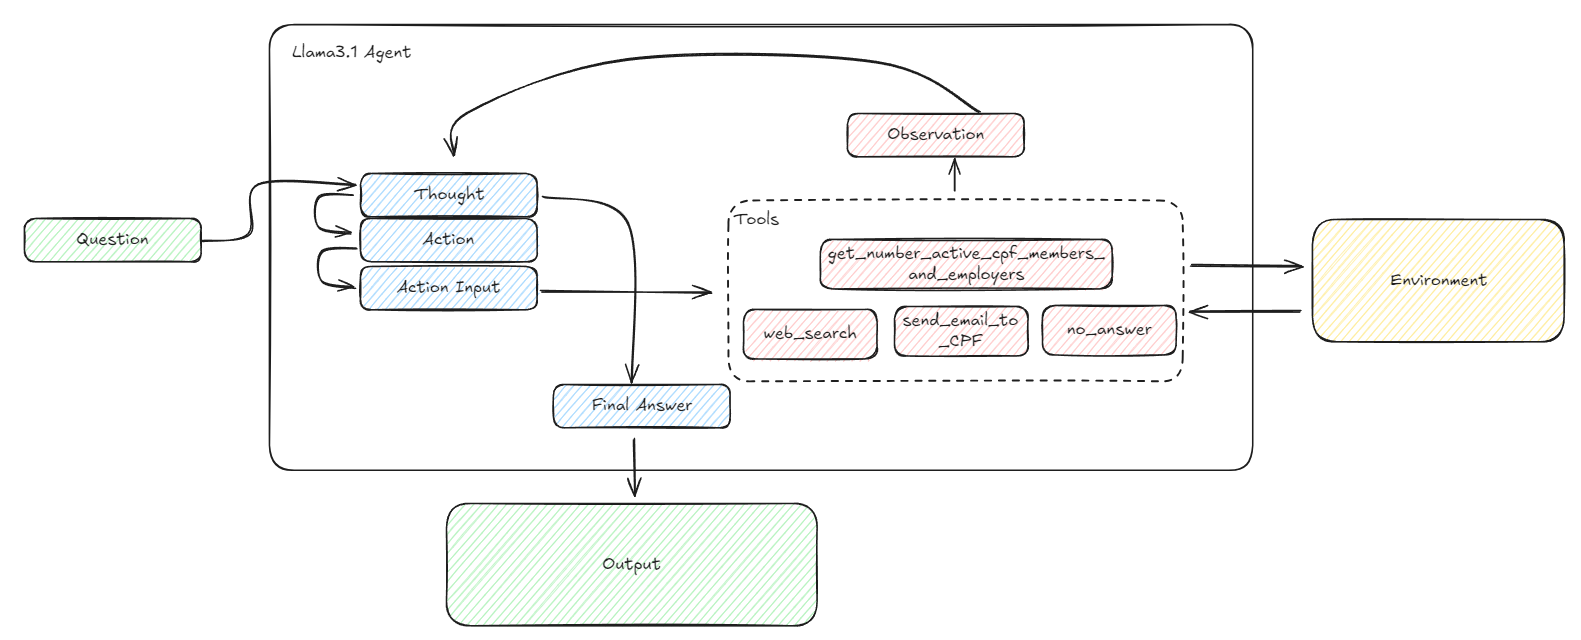

In [41]:
prompt = hub.pull("hwchase17/react")
print(prompt.template)

In [31]:
# We do this because the base prompt does not work at all without edits *cries*
# So we need to do some propmpt engineering to make the ReAct agent more relevant to our usecase and Llama 3.1 model

prompt.template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Thought: you should always think about what to do. If you have enough information, give your Final Answer. If the Observation says I don't know, use the no_answer tool or send_email_to_CPF depending on the Question.
Action: the action to take, should be one of [{tool_names}]
Action Input: the Action Input is the EXACT verbatim of the Question asked. Do not add or change the Question.
Observation: Additional information given by the tool that can be used in the Final Answer.

This Thought/Action/Action Input/Observation can repeat if you do not have enough information.

Once you have enough information to answer the user question, do the following:
Thought: I now know the final answer
Final Answer: ONLY give your final answer to the question that was asked.

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

In [32]:
memory = ChatMessageHistory(session_id="test-session")

In [33]:
# Create our agent and agent_executor

agent = create_react_agent(model, tools, prompt)

handler = StdOutCallbackHandler()
agent_executor = AgentExecutor(agent=agent, tools=tools, max_iterations=3, verbose=True, return_intermediate_steps=True, callbacks=[handler], handle_parsing_errors=True)


# This is used if we want to invoke queries while remembering previous user queries
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # This is needed because in most real world scenarios, a session id is needed
    # It isn't really used here because we are using a simple in memory ChatMessageHistory
    lambda session_id: memory,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [34]:
agent_executor.invoke(
    {"input": "How old do I need to be to claim CPF?"}
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I'm not sure what the age requirement is for claiming CPF. Let me try to find out.
Action: web_search
Action Input: What is the age limit to claim Central Provident Fund (CPF
Observation: I don't know. The context provided does not mention an age limit to claim the Central Provident Fund (CPF). It only provides information on what CPF is and its purpose, but not on any specific age-related requirements or limitations for claiming it.Thought: I still don't have enough information to answer the question. Let me try another tool.

Action: send_email_to_CPF
Action Input: I'm trying to find out how old you need to be to claim CPF, but I couldn't find any relevant information using a web searchHere's the email message:

Subject: Inquiry on Eligibility Age for Claiming CPF

Dear Central Provident Fund (CPF) Team,

I am writing to seek your assistance in understanding the eligibility age for claiming my CPF savings. I have been trying to find this information online, but unfortunately

{'input': 'How old do I need to be to claim CPF?',
 'output': "Here's the email message:\n\nSubject: Inquiry on Eligibility Age for Claiming CPF\n\nDear Central Provident Fund (CPF) Team,\n\nI am writing to seek your assistance in understanding the eligibility age for claiming my CPF savings. I have been trying to find this information online, but unfortunately, I couldn't locate any relevant details.\n\nCould you please provide me with information on the minimum age requirement to claim my CPF? I would appreciate it if you could also let me know what documents or procedures are required to initiate the claim process.\n\nThank you for your time and assistance. I look forward to hearing from you soon.\n\nBest regards,\n[Your Name]",
 'intermediate_steps': [(AgentAction(tool='web_search', tool_input='What is the age limit to claim Central Provident Fund (CPF', log="Thought: I'm not sure what the age requirement is for claiming CPF. Let me try to find out.\nAction: web_search\nAction Inpu

In [35]:
agent_executor.invoke(
    {"input": "What is CPF?"}
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I'm not sure what CPF stands for or what it means. I should try to find out more information.
Action: web_search
Action Input: What is CPF
Observation: The Central Provident Fund (CPF) is a mandatory social security system in Singapore that helps citizens save for retirement, housing, healthcare, and other needs. It is funded by contributions from employers and employees. The CPF has three main accounts: Ordinary, Special, and MediSave, each with different uses and benefits. The government also supplements the savings of lower-wage workers through various schemes. Overall, CPF serves as a key pillar of Singapore's social security system.Thought: I now know that CPF stands for Central Provident Fund, which is a mandatory social security system in Singapore.

Final Answer: The Central Provident Fund (CPF) is a mandatory social security system in Singapore that helps citizens save for retirement, housing, healthcare, and other needs.

> Finished chain.


{'input': 'What is CPF?',
 'output': 'The Central Provident Fund (CPF) is a mandatory social security system in Singapore that helps citizens save for retirement, housing, healthcare, and other needs.',
 'intermediate_steps': [(AgentAction(tool='web_search', tool_input='What is CPF', log="Thought: I'm not sure what CPF stands for or what it means. I should try to find out more information.\nAction: web_search\nAction Input: What is CPF"),
   "\nObservation: The Central Provident Fund (CPF) is a mandatory social security system in Singapore that helps citizens save for retirement, housing, healthcare, and other needs. It is funded by contributions from employers and employees. The CPF has three main accounts: Ordinary, Special, and MediSave, each with different uses and benefits. The government also supplements the savings of lower-wage workers through various schemes. Overall, CPF serves as a key pillar of Singapore's social security system.")]}

In [36]:
agent_executor.invoke(
    {"input": "How much CPF do employers need to contribute?"}
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I should try to find out how much CPF employers need to contribute. If I have enough information, I can give a Final Answer. 

Action: web_search
Action Input: How much CPF do employers need to contribute
Observation: Employers in Singapore are required to contribute up to 17% of their employees' salary, capped at $6,800 per month (previously $6,000). This contribution rate applies to employees earning more than $50 a month. The monthly salary ceiling is set to rise to $8,000 in 2026. There is no change to the Annual CPF Limit, which remains at $37,740.Thought: I now know that employers in Singapore are required to contribute up to 17% of their employees' salary, capped at $6,800 per month.

Final Answer: Employers in Singapore need to contribute up to 17% of their employees' salary, capped at $6,800 per month.

> Finished chain.


{'input': 'How much CPF do employers need to contribute?',
 'output': "Employers in Singapore need to contribute up to 17% of their employees' salary, capped at $6,800 per month.",
 'intermediate_steps': [(AgentAction(tool='web_search', tool_input='How much CPF do employers need to contribute', log='Thought: I should try to find out how much CPF employers need to contribute. If I have enough information, I can give a Final Answer. \n\nAction: web_search\nAction Input: How much CPF do employers need to contribute'),
   "\nObservation: Employers in Singapore are required to contribute up to 17% of their employees' salary, capped at $6,800 per month (previously $6,000). This contribution rate applies to employees earning more than $50 a month. The monthly salary ceiling is set to rise to $8,000 in 2026. There is no change to the Annual CPF Limit, which remains at $37,740.")]}

In [37]:
agent_executor.invoke(
    {"input": "What is the weather in Singapore tommorow?"}
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I don't have any information about the weather in Singapore. This question doesn't seem related to Central Provident Fund (CPF).

Action: no_answer
Action Input: What is the weather in Singapore tommorrowI'm so sorry, but I don't have access to real-time or future weather information for specific locations like Singapore. My training data only allows me to provide general information and answers based on my knowledge cutoff. Unfortunately, I won't be able to give you an accurate forecast for tomorrow in Singapore. If you're looking for up-to-date weather information, I recommend checking a reliable weather website or app, such as AccuWeather or the National Weather Service, for the most current forecasts. Sorry again for not being able to help!


> Finished chain.


{'input': 'What is the weather in Singapore tommorow?',
 'output': "I'm so sorry, but I don't have access to real-time or future weather information for specific locations like Singapore. My training data only allows me to provide general information and answers based on my knowledge cutoff. Unfortunately, I won't be able to give you an accurate forecast for tomorrow in Singapore. If you're looking for up-to-date weather information, I recommend checking a reliable weather website or app, such as AccuWeather or the National Weather Service, for the most current forecasts. Sorry again for not being able to help!",
 'intermediate_steps': [(AgentAction(tool='no_answer', tool_input='What is the weather in Singapore tommorrow', log="Thought: I don't have any information about the weather in Singapore. This question doesn't seem related to Central Provident Fund (CPF).\n\nAction: no_answer\nAction Input: What is the weather in Singapore tommorrow"),
   "I'm so sorry, but I don't have access 

In [38]:
agent_executor.invoke(
    {"input": "Thank you so much for helping me answer CPF related questions!"}
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: You're welcome! It's my pleasure to assist with Central Provident Fund (CPF) related queries. I'm ready to help!

Action: send_email_to_CPF
Action Input: Thank you so much for helping me answer CPF related questionsHere's the email message based on the user's query:

Subject: Appreciation for Assistance with CPF Queries

Dear Central Provident Fund (CPF) Team,

I am writing to express my sincere gratitude and appreciation for your assistance in answering my CPF-related questions. Your prompt and helpful responses have been invaluable, and I am grateful for the time you took to address my queries.

Your team's dedication to providing accurate and timely information has made a significant difference in helping me understand my CPF contributions and benefits. Please pass on my thanks to the entire team for their hard work and commitment to serving the public.

Thank you again for your assistance, and I wish the CPF team continued success in serving the community.

Best regards,
[

{'input': 'Thank you so much for helping me answer CPF related questions!',
 'output': "Here's the email message based on the user's query:\n\nSubject: Appreciation for Assistance with CPF Queries\n\nDear Central Provident Fund (CPF) Team,\n\nI am writing to express my sincere gratitude and appreciation for your assistance in answering my CPF-related questions. Your prompt and helpful responses have been invaluable, and I am grateful for the time you took to address my queries.\n\nYour team's dedication to providing accurate and timely information has made a significant difference in helping me understand my CPF contributions and benefits. Please pass on my thanks to the entire team for their hard work and commitment to serving the public.\n\nThank you again for your assistance, and I wish the CPF team continued success in serving the community.\n\nBest regards,\n[Your Name]",
 'intermediate_steps': [(AgentAction(tool='send_email_to_CPF', tool_input='Thank you so much for helping me an

In [39]:
agent_with_chat_history.invoke(
        {"input": "How many CPF active users are there?"},
        config={"configurable": {"session_id": "<foo>"}},
    )

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: I can use the get_number_active_cpf_members_and_employers tool to find out. If it's not available, I'll try web_searching for more information.

Action: get_number_active_cpf_members_and_employers
Action Input: How many CPF active users are there
Observation: 2160000Thought: I now know the final answer
Final Answer: 2,160,000

> Finished chain.


{'input': 'How many CPF active users are there?',
 'chat_history': [],
 'output': '2,160,000',
 'intermediate_steps': [(AgentAction(tool='get_number_active_cpf_members_and_employers', tool_input='How many CPF active users are there', log="Thought: I can use the get_number_active_cpf_members_and_employers tool to find out. If it's not available, I'll try web_searching for more information.\n\nAction: get_number_active_cpf_members_and_employers\nAction Input: How many CPF active users are there"),
   '\nObservation: 2160000')]}